# <center> Предсказание победителя в Dota 2


[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

Статистику игроков (префикс 'r' для команды Radiant, 'd' для Dire), которая включает поля:

hero_id - id героя

K/D/A: количество убийств, смертей и помощи.

lh - last hits - число убитых вражеских крипов.

denies - число добитых собственных крипов с целью не дать врагу золото.

gold - количество золота у персонажа.

xp - количество опыта у персонажа.

level - уровень героя.

health and max_health - здоровье и максимальное значение здоровья.

max_mana - максимальное количество маны (мана нужна для использования способностей).

x, y - текущие координаты игрока на карте.

stuns - сколько секунд герой продержал врагов в оглушении.

camps_stacked - сложная механика для первого раза, но чем она выше, тем проще команде получать золото.

rune_pickups - число найденных рун (они дают разные временные бонусы, например, увеличение урона).

firstblood_claimed - сделал ли игрок первое убийство в игре (обычно за это дают больше золота).

teamfight_participation - в каком проценте сражений поучаствовал персонаж.

towers_killed - число разрушенных вышек.

roshans_killed - число убитых Рошанов (дает возможность одному из героев команды сразу возродиться после сметри).

obs_placed, sen_placed - число Observer и Sentry вардов, установленных игроком (первые дают обзор на карте, а вторые показывают невидимых героев при наличии обзора в данной области, а также вражеские варды).

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [60]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import (XGBClassifier, XGBRFClassifier)

In [61]:
import os
import numpy as np
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [62]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [63]:
PATH_TO_DATA = "/kaggle/input/copy-of-23-24-ml/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")

In [64]:
df_train_features.shape 
#245-признаков (колонок)
#31698 наблюдений

(31698, 245)

In [65]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [66]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [67]:
target = pd.Series(df_train_targets['radiant_win'].map({True: 1, False: 0}))

Text(0.5, 1.0, 'Target distribution')

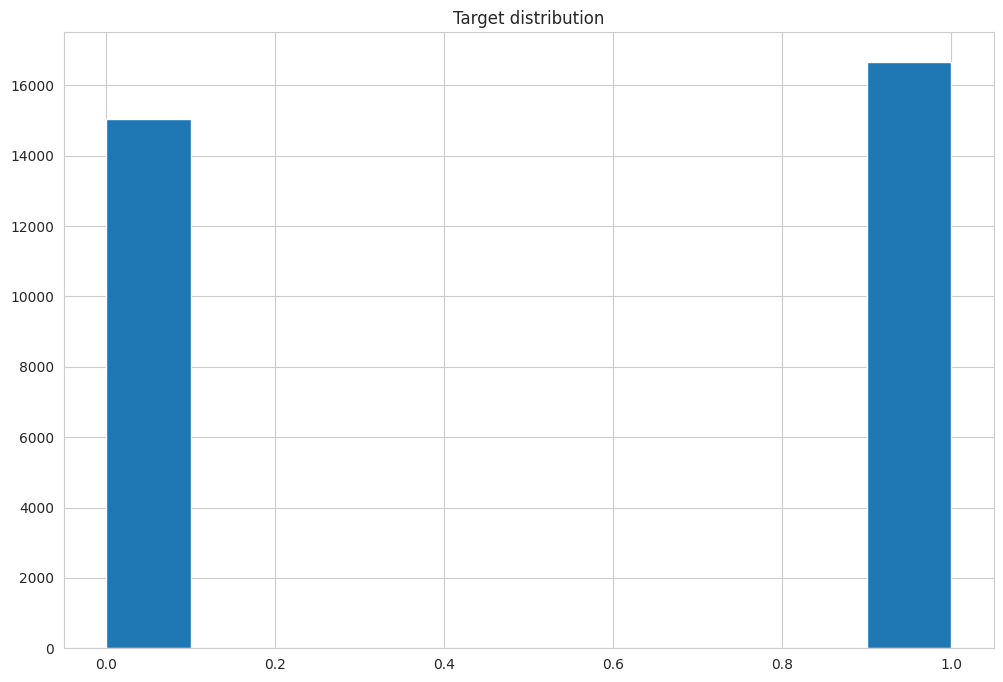

In [68]:
plt.hist(target);
plt.title('Target distribution')
#'radiant_win' - преобладает немного

In [69]:
df_train_features.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r1_kills', 'r1_deaths', 'r1_assists', 'r1_denies',
       ...
       'd5_stuns', 'd5_creeps_stacked', 'd5_camps_stacked', 'd5_rune_pickups',
       'd5_firstblood_claimed', 'd5_teamfight_participation',
       'd5_towers_killed', 'd5_roshans_killed', 'd5_obs_placed',
       'd5_sen_placed'],
      dtype='object', length=245)

In [70]:
#Анализ корреляции признаков координат с победой
print('Top 10 features correlated with target (abs values):')
print(abs(df_train_features.corrwith(target)).sort_values(ascending=False)[0:10])

Top 10 features correlated with target (abs values):
r1_y    0.202537
d2_y    0.202515
r2_y    0.202448
d3_y    0.202387
r3_y    0.202271
r4_y    0.199185
d4_y    0.198917
r5_y    0.198795
d5_y    0.197397
d1_y    0.196519
dtype: float64


## <left>Наша первая модель

In [71]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

#### Обучим случайный лес

In [73]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 34.6 s, sys: 122 ms, total: 34.7 s
Wall time: 9.26 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [74]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [75]:
X_valid.shape #9510 - наблюдений

(9510, 245)

In [76]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)
#ROC-AUC score на отложенной части: 0.7754387258058622

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [77]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)
#Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [78]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [79]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))
#Файл посылки сохранен, как: submission_2024-04-02_10-59-25.csv

Файл посылки сохранен, как: submission_2024-04-05_10-47-00.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [80]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [81]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

KeyboardInterrupt: 

In [82]:
cv_scores_rf
#array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

NameError: name 'cv_scores_rf' is not defined

In [ ]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")
#Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513

## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [ ]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)
#match.keys  ['game_time','match_id_hash','teamfights','objectives','chat','game_mode', 'lobby_type', 'players', 'targets']


In [ ]:
match.keys()

In [ ]:
#match['players'][9]['xp_t']

In [ ]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [ ]:
player["ability_uses"]

In [ ]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");
#По графику XP change можно видеть, как опыт (xp) увеличивается со временем.

In [ ]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players')

#Изменение кол-ва золота для игроков

На основе данных статьи - Gold и XP считаются самыми значимыми признаками, приводящими игроков к успеху.

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [ ]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [ ]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

Добавляются новые признаки: radiant_tower_kills, dire_tower_kills, diff_tower_kills.

In [ ]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

In [ ]:
df_train_features_extended.head()

In [ ]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [ ]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

## Gold and XP difference 

In [ ]:
traindf = df_train_features_extended.copy()

In [ ]:
traindf['radiant_gold'] = traindf['r1_gold'] + traindf['r2_gold'] + traindf['r3_gold'] + traindf['r4_gold'] + traindf['r5_gold']
traindf['radiant_xp'] = traindf['r1_xp'] + traindf['r2_xp'] + traindf['r3_xp'] + traindf['r4_xp'] + traindf['r5_xp']
traindf['radiant_gold_xp_ratio'] = traindf['radiant_gold']/traindf['radiant_xp']
traindf['radiant_vision'] = traindf['r1_obs_placed'] + traindf['r2_obs_placed'] + traindf['r3_obs_placed'] + traindf['r4_obs_placed'] + traindf['r5_obs_placed'] + traindf['r1_sen_placed'] + traindf['r2_sen_placed'] + traindf['r3_sen_placed'] + traindf['r4_sen_placed'] + traindf['r5_sen_placed']
traindf['radiant_sen'] = traindf['r1_sen_placed'] + traindf['r2_sen_placed'] + traindf['r3_sen_placed'] + traindf['r4_sen_placed'] + traindf['r5_sen_placed']
traindf['radiant_stun'] = traindf['r1_stuns'] + traindf['r2_stuns'] + traindf['r3_stuns'] + traindf['r4_stuns'] + traindf['r5_stuns']

In [ ]:
traindf['dire_gold'] = traindf['d1_gold'] + traindf['d2_gold'] + traindf['d3_gold'] + traindf['d4_gold'] + traindf['d5_gold']
traindf['dire_xp'] = traindf['d1_xp'] + traindf['d2_xp'] + traindf['d3_xp'] + traindf['d4_xp'] + traindf['d5_xp']
traindf['dire_gold_xp_ratio'] = traindf['dire_gold']/traindf['dire_xp']
traindf['dire_vision'] = traindf['d1_obs_placed'] + traindf['d2_obs_placed'] + traindf['d3_obs_placed'] + traindf['d4_obs_placed'] + traindf['d5_obs_placed'] + traindf['d1_sen_placed'] + traindf['d2_sen_placed'] + traindf['d3_sen_placed'] + traindf['d4_sen_placed'] + traindf['d5_sen_placed']
traindf['dire_sen'] = traindf['d1_sen_placed'] + traindf['d2_sen_placed'] + traindf['d3_sen_placed'] + traindf['d4_sen_placed'] + traindf['d5_sen_placed']
traindf['dire_stun'] = traindf['d1_stuns'] + traindf['d2_stuns'] + traindf['d3_stuns'] + traindf['d4_stuns'] + traindf['d5_stuns']

In [ ]:
traindf['dif_gold'] = traindf['radiant_gold'] - traindf['dire_gold']
traindf['dif_xp'] = traindf['radiant_xp'] - traindf['dire_xp']
traindf['dif_gold_xp_ratio'] = traindf['radiant_gold_xp_ratio']/traindf['dire_gold_xp_ratio']
traindf['dif_vision'] = traindf['radiant_vision'] - traindf['dire_vision']
traindf['dif_sen'] = traindf['radiant_sen'] - traindf['dire_sen']
traindf = traindf.replace([np.inf, -np.inf], np.nan).fillna(0)

In [ ]:
traindf['target'] = target
cor = traindf.corr()
cor_target = cor['target']
cor_target = cor_target.sort_values(ascending=False)
print(cor_target.head(10))


selected_col = cor.head(10).index 
tempdf = traindf[selected_col]
f, ax = plt.subplots(figsize=(12, 9))
cor2 = tempdf.corr()
sns.heatmap(cor2, vmax=.8, annot=True, square=True, cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5 )
plt.show()

#Наибольшая корреляция с target(radian win) для следующих признаков
#dif_gold            0.472234
#dif_xp              0.451624
#diff_tower_kills    0.417196

## KDA


Добавляю новый признак - KDA. С ним модель лучше предсказывает.

In [ ]:
r_kills = ['r{0}_kills'.format(i) for i in range(1,6)]
r_deaths = ['r{0}_deaths'.format(i) for i in range(1,6)]
r_assists = ['r{0}_assists'.format(i) for i in range(1,6)]
r_kda = r_kills+r_deaths+r_assists

d_kills = ['d{0}_kills'.format(i) for i in range(1,6)]
d_deaths = ['d{0}_deaths'.format(i) for i in range(1,6)]
d_assists = ['d{0}_assists'.format(i) for i in range(1,6)]
d_kda = d_kills+d_deaths+d_assists

kda_feat_df = df_train_features[r_kda+d_kda].copy()
kda_feat_df['target'] = target

kda_feat_df['r_tot_kills'] = kda_feat_df[r_kills].sum(axis=1)
kda_feat_df['r_tot_deaths'] = kda_feat_df[r_deaths].sum(axis=1)
kda_feat_df['r_tot_assists'] = kda_feat_df[r_assists].sum(axis=1)

kda_feat_df['d_tot_kills'] = kda_feat_df[d_kills].sum(axis=1)
kda_feat_df['d_tot_deaths'] = kda_feat_df[d_deaths].sum(axis=1)
kda_feat_df['d_tot_assists'] = kda_feat_df[d_assists].sum(axis=1)

tot_cols = ['r_tot_kills', 'r_tot_deaths', 'r_tot_assists', 'd_tot_kills', 'd_tot_deaths', 'd_tot_assists']

In [ ]:
display(kda_feat_df.head(3))

In [ ]:
plt.figure(figsize=(8, 5));
ax = sns.heatmap(kda_feat_df[tot_cols+['target']].corr(),annot=True,)

In [ ]:
kda_feat_df['r_kda'] = (kda_feat_df['r_tot_kills']+kda_feat_df['r_tot_assists'])/kda_feat_df['r_tot_deaths']
kda_feat_df['d_kda'] = (kda_feat_df['d_tot_kills']+kda_feat_df['d_tot_assists'])/kda_feat_df['d_tot_deaths']

In [ ]:
plt.figure(figsize=(4.8, 3));
ax = sns.heatmap(kda_feat_df[['r_kda','d_kda','target']].corr(),annot=True,)

#Other feauteres could be analyzed in the same way.
#Even more data is stored in JSON files.

### Кроссвалидация нескольких моделей, сравнение результатов и отбор наиболее успешной модели. 

In [ ]:
%%time

model_lgb = LGBMClassifier(random_state=SEED)
cv_scores_lgb = cross_val_score(model_lgb, X, y, cv=cv, 
                                scoring='roc_auc', n_jobs=4)

In [ ]:
%%time

model_xgb = XGBClassifier(random_state=SEED)
cv_scores_xgb = cross_val_score(model_xgb, X, y, cv=cv,
                                scoring='roc_auc', n_jobs=4)

In [ ]:
%%time

model_cat = CatBoostClassifier(random_state=SEED,silent=True)
cv_scores_cat = cross_val_score(model_cat, X, y, cv=cv,
                                scoring='roc_auc', n_jobs=1)

In [ ]:
cv_results = pd.DataFrame(data={'RF': cv_scores_rf, 'LGB':cv_scores_lgb, 'XGB':cv_scores_xgb, 'CAT':cv_scores_cat})
cv_results.describe()

### First submission (без добавления новых признаков), CatBoostClassifier

In [ ]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

model_cat.fit(X, y)

X_test = df_test_features.values

y_test_pred = model_cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [ ]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(f"/kaggle/working/{submission_filename}")
print("Файл посылки сохранен, как: {}".format(submission_filename))
#Файл посылки сохранен, как: 

### Теперь я хочу проверить работу модели после добавления новых признаков: KDA, Gold and XP difference, Tower diff

In [ ]:

df_train_features_extended["r_kda"] = kda_feat_df['r_kda']
df_train_features_extended["d_kda"] = kda_feat_df['d_kda']
df_train_features_extended["dif_gold"] = traindf['dif_gold'] 
df_train_features_extended["dif_xp"] = traindf['dif_xp'] 
df_train_features_extended["dif_gold_xp_ratio"] = traindf['dif_gold_xp_ratio'] 
df_train_features_extended["dif_vision"] = traindf['dif_vision'] 
df_train_features_extended["dif_sen"] = traindf['dif_sen'] 

In [ ]:
X2 = df_train_features_extended.values

In [ ]:
cv_scores_cat2 = cross_val_score(model_cat, X2, y, cv=cv,
                                scoring='roc_auc', n_jobs=1)
cat_results = pd.DataFrame(data={'CAT':cv_scores_cat, 'CAT_extended':cv_scores_cat2})
cat_results.describe()
#roc_auc score для CAT_extended (содержит новые признаки)-выше!

- Можно увидеть, что после добавления новых признаков, точность предсказывания модели увеличилась.

In [ ]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")

In [ ]:
df_test_features_extended = df_test_features.copy()

In [84]:
df_test_features_extended.shape

(7977, 245)

- Добавляю новые признаки в тестовый датасет.

In [89]:
traindf = df_test_features_extended.copy()
traindf['radiant_gold'] = traindf['r1_gold'] + traindf['r2_gold'] + traindf['r3_gold'] + traindf['r4_gold'] + traindf['r5_gold']
traindf['radiant_xp'] = traindf['r1_xp'] + traindf['r2_xp'] + traindf['r3_xp'] + traindf['r4_xp'] + traindf['r5_xp']
traindf['radiant_gold_xp_ratio'] = traindf['radiant_gold']/traindf['radiant_xp']
traindf['radiant_vision'] = traindf['r1_obs_placed'] + traindf['r2_obs_placed'] + traindf['r3_obs_placed'] + traindf['r4_obs_placed'] + traindf['r5_obs_placed'] + traindf['r1_sen_placed'] + traindf['r2_sen_placed'] + traindf['r3_sen_placed'] + traindf['r4_sen_placed'] + traindf['r5_sen_placed']
traindf['radiant_sen'] = traindf['r1_sen_placed'] + traindf['r2_sen_placed'] + traindf['r3_sen_placed'] + traindf['r4_sen_placed'] + traindf['r5_sen_placed']
traindf['radiant_stun'] = traindf['r1_stuns'] + traindf['r2_stuns'] + traindf['r3_stuns'] + traindf['r4_stuns'] + traindf['r5_stuns']
traindf['dire_gold'] = traindf['d1_gold'] + traindf['d2_gold'] + traindf['d3_gold'] + traindf['d4_gold'] + traindf['d5_gold']
traindf['dire_xp'] = traindf['d1_xp'] + traindf['d2_xp'] + traindf['d3_xp'] + traindf['d4_xp'] + traindf['d5_xp']
traindf['dire_gold_xp_ratio'] = traindf['dire_gold']/traindf['dire_xp']
traindf['dire_vision'] = traindf['d1_obs_placed'] + traindf['d2_obs_placed'] + traindf['d3_obs_placed'] + traindf['d4_obs_placed'] + traindf['d5_obs_placed'] + traindf['d1_sen_placed'] + traindf['d2_sen_placed'] + traindf['d3_sen_placed'] + traindf['d4_sen_placed'] + traindf['d5_sen_placed']
traindf['dire_sen'] = traindf['d1_sen_placed'] + traindf['d2_sen_placed'] + traindf['d3_sen_placed'] + traindf['d4_sen_placed'] + traindf['d5_sen_placed']
traindf['dire_stun'] = traindf['d1_stuns'] + traindf['d2_stuns'] + traindf['d3_stuns'] + traindf['d4_stuns'] + traindf['d5_stuns']
traindf['dif_gold'] = traindf['radiant_gold'] - traindf['dire_gold']
traindf['dif_xp'] = traindf['radiant_xp'] - traindf['dire_xp']
traindf['dif_gold_xp_ratio'] = traindf['radiant_gold_xp_ratio']/traindf['dire_gold_xp_ratio']
traindf['dif_vision'] = traindf['radiant_vision'] - traindf['dire_vision']
traindf['dif_sen'] = traindf['radiant_sen'] - traindf['dire_sen']
traindf = traindf.replace([np.inf, -np.inf], np.nan).fillna(0)

In [91]:
kda_feat_df = df_test_features[r_kda+d_kda].copy()
kda_feat_df['target'] = target

kda_feat_df['r_tot_kills'] = kda_feat_df[r_kills].sum(axis=1)
kda_feat_df['r_tot_deaths'] = kda_feat_df[r_deaths].sum(axis=1)
kda_feat_df['r_tot_assists'] = kda_feat_df[r_assists].sum(axis=1)

kda_feat_df['d_tot_kills'] = kda_feat_df[d_kills].sum(axis=1)
kda_feat_df['d_tot_deaths'] = kda_feat_df[d_deaths].sum(axis=1)
kda_feat_df['d_tot_assists'] = kda_feat_df[d_assists].sum(axis=1)

tot_cols = ['r_tot_kills', 'r_tot_deaths', 'r_tot_assists', 'd_tot_kills', 'd_tot_deaths', 'd_tot_assists']

In [92]:
kda_feat_df['r_kda'] = (kda_feat_df['r_tot_kills']+kda_feat_df['r_tot_assists'])/kda_feat_df['r_tot_deaths']
kda_feat_df['d_kda'] = (kda_feat_df['d_tot_kills']+kda_feat_df['d_tot_assists'])/kda_feat_df['d_tot_deaths']

In [93]:
df_test_features_extended["r_kda"] = kda_feat_df['r_kda']
df_test_features_extended["d_kda"] = kda_feat_df['d_kda']
df_test_features_extended["dif_gold"] = traindf['dif_gold'] 
df_test_features_extended["dif_xp"] = traindf['dif_xp'] 
df_test_features_extended["dif_gold_xp_ratio"] = traindf['dif_gold_xp_ratio'] 
df_test_features_extended["dif_vision"] = traindf['dif_vision'] 
df_test_features_extended["dif_sen"] = traindf['dif_sen']

In [85]:
add_new_features(df_test_features_extended,
                 os.path.join(PATH_TO_DATA,"test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [94]:
df_test_features_extended.shape
#добавили 10 новых признаков в тестовый датасет

(7977, 255)

### Final submission (с новыми признаками)

In [96]:
model_cat.fit(X2, y)

X_test = df_test_features_extended.values

y_test_pred = model_cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [98]:
df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)

In [100]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(f"/kaggle/working/{submission_filename}")
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-05_11-16-59.csv
